mkdir house-prices-starter
cd house-prices-starter
python -m venv venv
.venv\Scripts\activate     # On Windows

pip install pandas numpy scikit-learn kaggle

mkdir .kaggle
# Move the kaggle.json into .kaggle
# On Windows (adjust path to where you downloaded kaggle.json):
move path\to\kaggle.json .kaggle\kaggle.json

# Set environment variable (relative path from project root):
set KAGGLE_CONFIG_DIR=.kaggle   # Windows
# export KAGGLE_CONFIG_DIR=.kaggle   # macOS/Linux

# Fix Kaggle API 401 Unauthorized (Windows PowerShell)

1. **Download API key** from [Kaggle Account](https://www.kaggle.com/account) → Create New API Token → save `kaggle.json`.

2. **Place `kaggle.json`** in `.kaggle` folder inside your project root.

3. **Set env variable in PowerShell (use relative path from project root):**

```powershell
$env:KAGGLE_CONFIG_DIR = ".kaggle"

grep -qxF ".kaggle/kaggle.json" .gitignore || echo ".kaggle/kaggle.json" >> .gitignore

kaggle competitions download -c house-prices-advanced-regression-techniques
move .\house-prices-advanced-regression-techniques.zip .\data\
Remove-Item .\data\house-prices-advanced-regression-techniques.zip

In [ ]:
# Create folders if missing
$folders = @("notebooks", "scripts", "submissions", ".kaggle")

foreach ($folder in $folders) {
    if (-Not (Test-Path $folder)) {
        New-Item -ItemType Directory -Path $folder | Out-Null
        Write-Host "Created folder: $folder"
    } else {
        Write-Host "Folder already exists: $folder"
    }
}

# Create empty files if missing
$files = @("README.md", "requirements.txt")

foreach ($file in $files) {
    if (-Not (Test-Path $file)) {
        New-Item -ItemType File -Path $file | Out-Null
        Write-Host "Created file: $file"
    } else {
        Write-Host "File already exists: $file"
    }
}

# Comprehensive Model Comparison

This section provides a detailed comparison of all trained models, including:
- Statistical summary of predictions
- Performance metrics (RMSE, Kaggle scores)
- Prediction correlations
- Distribution comparisons
- Model rankings


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add project root to path
sys.path.insert(0, str(Path().resolve().parent.parent))

from config_local import local_config as config
from scripts.compare_models import load_all_submissions

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Load all model predictions
print("Loading all model submissions...")
df_predictions = load_all_submissions(config.SUBMISSIONS_DIR)
print(f"\nLoaded {len(df_predictions.columns)} models:")
print(df_predictions.columns.tolist())


Loading all model submissions...

Loaded 11 models:
['0_linear_regression', '10_blending', '11_stacking', '2_ridge', '3_lasso', '4_elastic_net', '5_random_forest', '6_svr', '7_xgboost', '8_lightgbm', '9_catboost']


In [2]:
# Load performance metrics
df_performance = pd.read_csv(config.MODEL_PERFORMANCE_CSV)
df_performance['timestamp'] = pd.to_datetime(df_performance['timestamp'])

# Get latest performance for each model
latest_performance = df_performance.sort_values('timestamp').groupby('model').last().reset_index()

# Filter to only models with valid predictions (not exploded)
valid_models = [col for col in df_predictions.columns if df_predictions[col].mean() < 1e7]
print(f"\nValid models (not exploded): {len(valid_models)}")
print(f"Invalid models (exploded): {len(df_predictions.columns) - len(valid_models)}")

# Create comprehensive comparison dataframe
comparison_data = []

for model_name in valid_models:
    preds = df_predictions[model_name]
    
    # Find matching performance data
    perf_match = latest_performance[latest_performance['model'].str.contains(model_name.split('_')[0], case=False, na=False)]
    if len(perf_match) > 0:
        rmse = perf_match.iloc[0]['rmse']
        kaggle_score = perf_match.iloc[0]['kaggle_score'] if pd.notna(perf_match.iloc[0]['kaggle_score']) else None
    else:
        rmse = None
        kaggle_score = None
    
    comparison_data.append({
        'Model': model_name,
        'Mean': preds.mean(),
        'Median': preds.median(),
        'Std': preds.std(),
        'Min': preds.min(),
        'Max': preds.max(),
        'Q25': preds.quantile(0.25),
        'Q75': preds.quantile(0.75),
        'RMSE': rmse,
        'Kaggle_Score': kaggle_score
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('Mean')

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(df_comparison.to_string(index=False))



Valid models (not exploded): 6
Invalid models (exploded): 5

MODEL COMPARISON SUMMARY
          Model          Mean        Median          Std          Min           Max           Q25           Q75 RMSE Kaggle_Score
    10_blending 175886.047563 159148.146631 68336.890495 68128.436518 449878.150602 128489.685712 201776.753611 None         None
5_random_forest 177058.036754 157083.151043 75144.062036 55782.710476 540118.933255 127456.110496 205966.349275 None         None
          6_svr 177637.058181 156547.227216 72158.647266 51452.369505 558044.033699 132558.623949 201465.635370 None         None
      7_xgboost 177683.363082 157675.810000 77973.999629 45965.370000 580416.250000 127512.465000 207738.710000 None         None
     9_catboost 177857.424768 158065.050905 77745.742017 46651.423906 573022.212080 126904.710865 205834.228934 None         None
     8_lightgbm 178422.402374 156882.313631 78689.771664 56649.377977 514619.687983 128059.839492 206170.106373 None         None


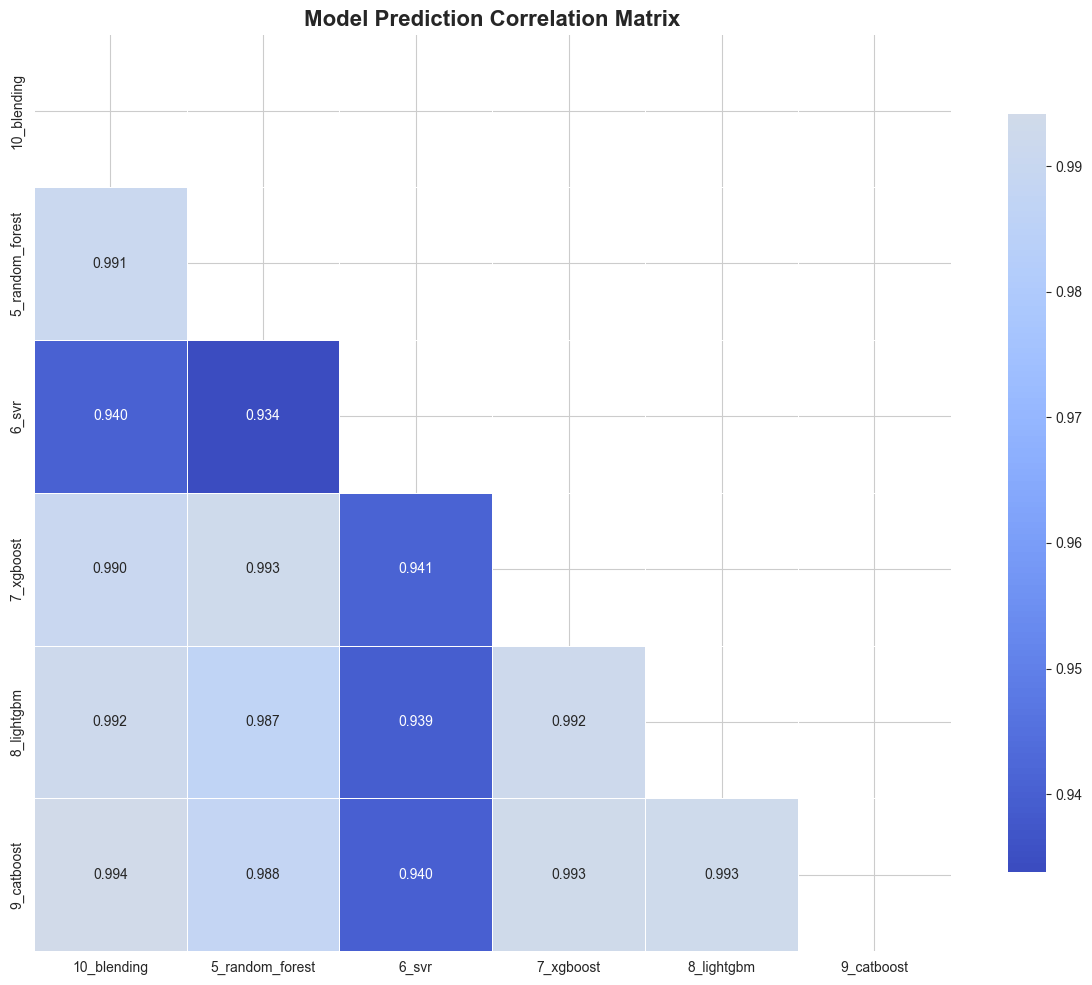


Correlation Insights:
- High correlation (>0.95) indicates models make similar predictions
- Low correlation (<0.90) suggests diverse model approaches
- Ensemble models (blending/stacking) should have moderate correlation with base models


In [3]:
# Correlation matrix between models
df_valid = df_predictions[valid_models]
corr_matrix = df_valid.corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".3f", cmap="coolwarm", 
            center=1, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Model Prediction Correlation Matrix", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation Insights:")
print("- High correlation (>0.95) indicates models make similar predictions")
print("- Low correlation (<0.90) suggests diverse model approaches")
print("- Ensemble models (blending/stacking) should have moderate correlation with base models")


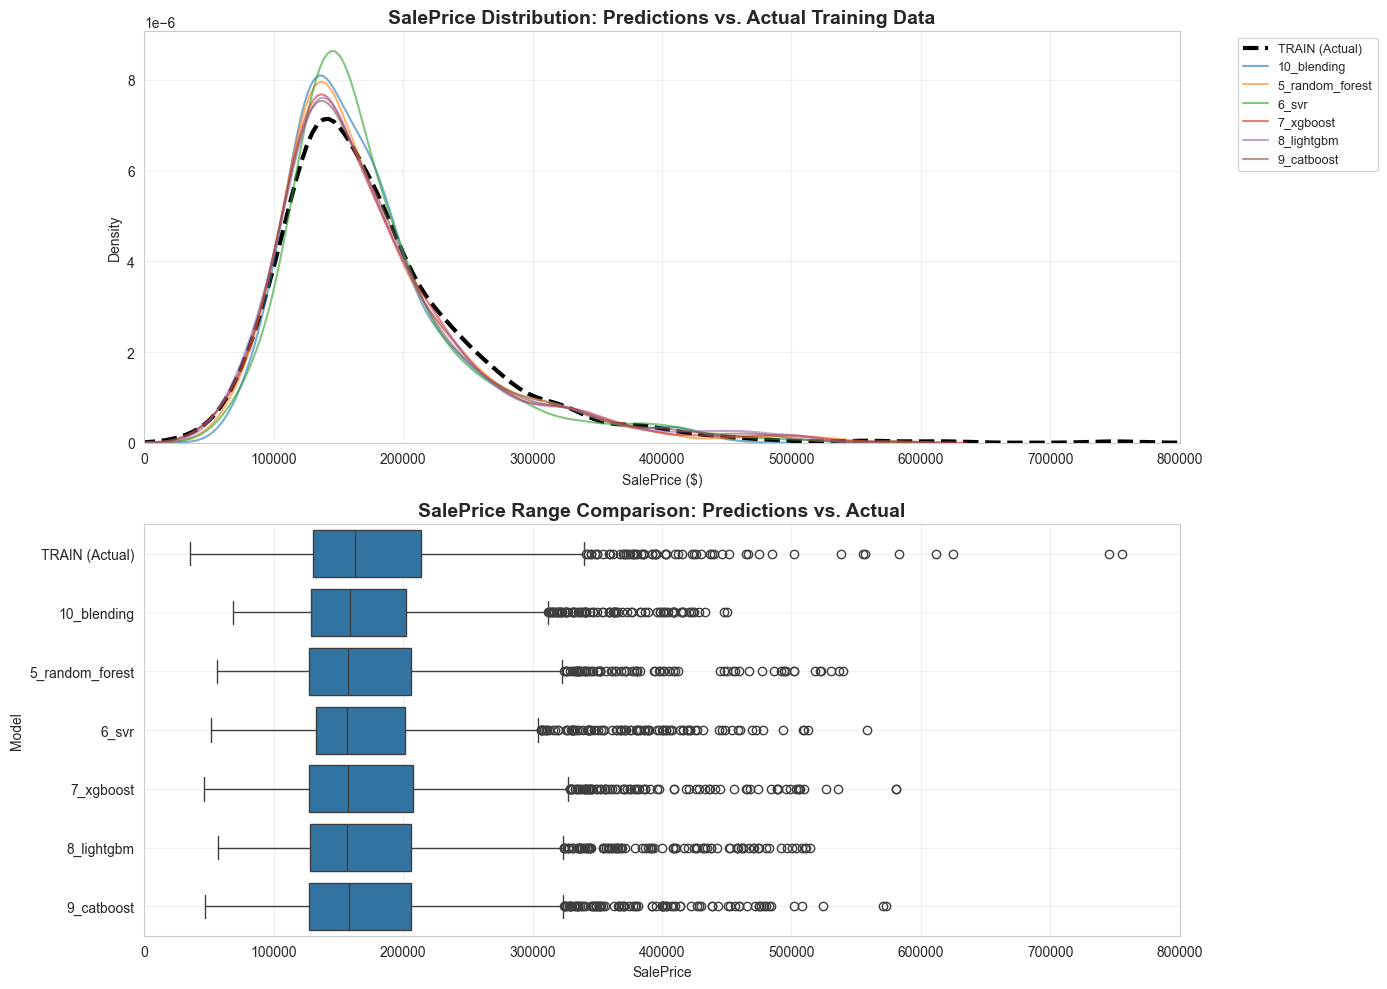

In [4]:
# Load training data for reference
try:
    train_df = pd.read_csv(config.TRAIN_PROCESS6_CSV)
    y_train = np.expm1(train_df["logSP"])
    
    # Distribution comparison
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # KDE Plot
    ax1 = axes[0]
    sns.kdeplot(y_train, label="TRAIN (Actual)", color="black", linewidth=3, linestyle="--", ax=ax1)
    for col in valid_models:
        sns.kdeplot(df_valid[col], label=col, alpha=0.6, ax=ax1)
    ax1.set_title("SalePrice Distribution: Predictions vs. Actual Training Data", fontsize=14, fontweight='bold')
    ax1.set_xlabel("SalePrice ($)")
    ax1.set_xlim(0, 800000)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Boxplot
    ax2 = axes[1]
    df_melted = df_valid.melt(var_name="Model", value_name="SalePrice")
    train_melted = pd.DataFrame({"Model": ["TRAIN (Actual)"] * len(y_train), "SalePrice": y_train})
    df_plot = pd.concat([train_melted, df_melted], ignore_index=True)
    
    sns.boxplot(x="SalePrice", y="Model", data=df_plot, ax=ax2)
    ax2.set_title("SalePrice Range Comparison: Predictions vs. Actual", fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 800000)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Could not load training data: {e}")


In [5]:
# Model ranking by different metrics
print("\n" + "="*80)
print("MODEL RANKINGS")
print("="*80)

# Rank by mean prediction (closest to expected)
df_comparison['Rank_Mean'] = df_comparison['Mean'].rank(ascending=True)

# Rank by RMSE (if available)
if df_comparison['RMSE'].notna().any():
    df_comparison['Rank_RMSE'] = df_comparison['RMSE'].rank(ascending=True)

# Rank by Kaggle score (if available)
if df_comparison['Kaggle_Score'].notna().any():
    df_comparison['Rank_Kaggle'] = df_comparison['Kaggle_Score'].rank(ascending=True)

# Rank by prediction stability (lower std is better)
df_comparison['Rank_Stability'] = df_comparison['Std'].rank(ascending=True)

# Display rankings
ranking_cols = ['Model', 'Mean', 'Std', 'RMSE', 'Kaggle_Score']
if 'Rank_RMSE' in df_comparison.columns:
    ranking_cols.append('Rank_RMSE')
if 'Rank_Kaggle' in df_comparison.columns:
    ranking_cols.append('Rank_Kaggle')
ranking_cols.append('Rank_Stability')

print("\nRanked by RMSE (lower is better):")
if 'Rank_RMSE' in df_comparison.columns:
    print(df_comparison[['Model', 'RMSE', 'Rank_RMSE']].sort_values('Rank_RMSE').to_string(index=False))
else:
    print("No RMSE data available")

print("\nRanked by Kaggle Score (lower is better):")
if 'Rank_Kaggle' in df_comparison.columns:
    print(df_comparison[['Model', 'Kaggle_Score', 'Rank_Kaggle']].sort_values('Rank_Kaggle').to_string(index=False))
else:
    print("No Kaggle score data available")

print("\nRanked by Prediction Stability (lower std is better):")
print(df_comparison[['Model', 'Std', 'Rank_Stability']].sort_values('Rank_Stability').to_string(index=False))



MODEL RANKINGS

Ranked by RMSE (lower is better):
No RMSE data available

Ranked by Kaggle Score (lower is better):
No Kaggle score data available

Ranked by Prediction Stability (lower std is better):
          Model          Std  Rank_Stability
    10_blending 68336.890495             1.0
          6_svr 72158.647266             2.0
5_random_forest 75144.062036             3.0
     9_catboost 77745.742017             4.0
      7_xgboost 77973.999629             5.0
     8_lightgbm 78689.771664             6.0



Pairwise Differences Between Top Models: 10_blending, 7_xgboost, 8_lightgbm, 9_catboost

10_blending vs 7_xgboost:
  Mean difference: $-1,797.32
  Std of differences: $14,013.08
  Max absolute difference: $132,839.61
  Correlation: 0.9903

10_blending vs 8_lightgbm:
  Mean difference: $-2,536.35
  Std of differences: $13,720.17
  Max absolute difference: $93,725.29
  Correlation: 0.9925

10_blending vs 9_catboost:
  Mean difference: $-1,971.38
  Std of differences: $12,268.05
  Max absolute difference: $125,473.26
  Correlation: 0.9942

7_xgboost vs 8_lightgbm:
  Mean difference: $-739.04
  Std of differences: $9,775.94
  Max absolute difference: $81,925.23
  Correlation: 0.9923

7_xgboost vs 9_catboost:
  Mean difference: $-174.06
  Std of differences: $9,013.89
  Max absolute difference: $62,929.91
  Correlation: 0.9933

8_lightgbm vs 9_catboost:
  Mean difference: $564.98
  Std of differences: $9,386.94
  Max absolute difference: $84,177.53
  Correlation: 0.9929


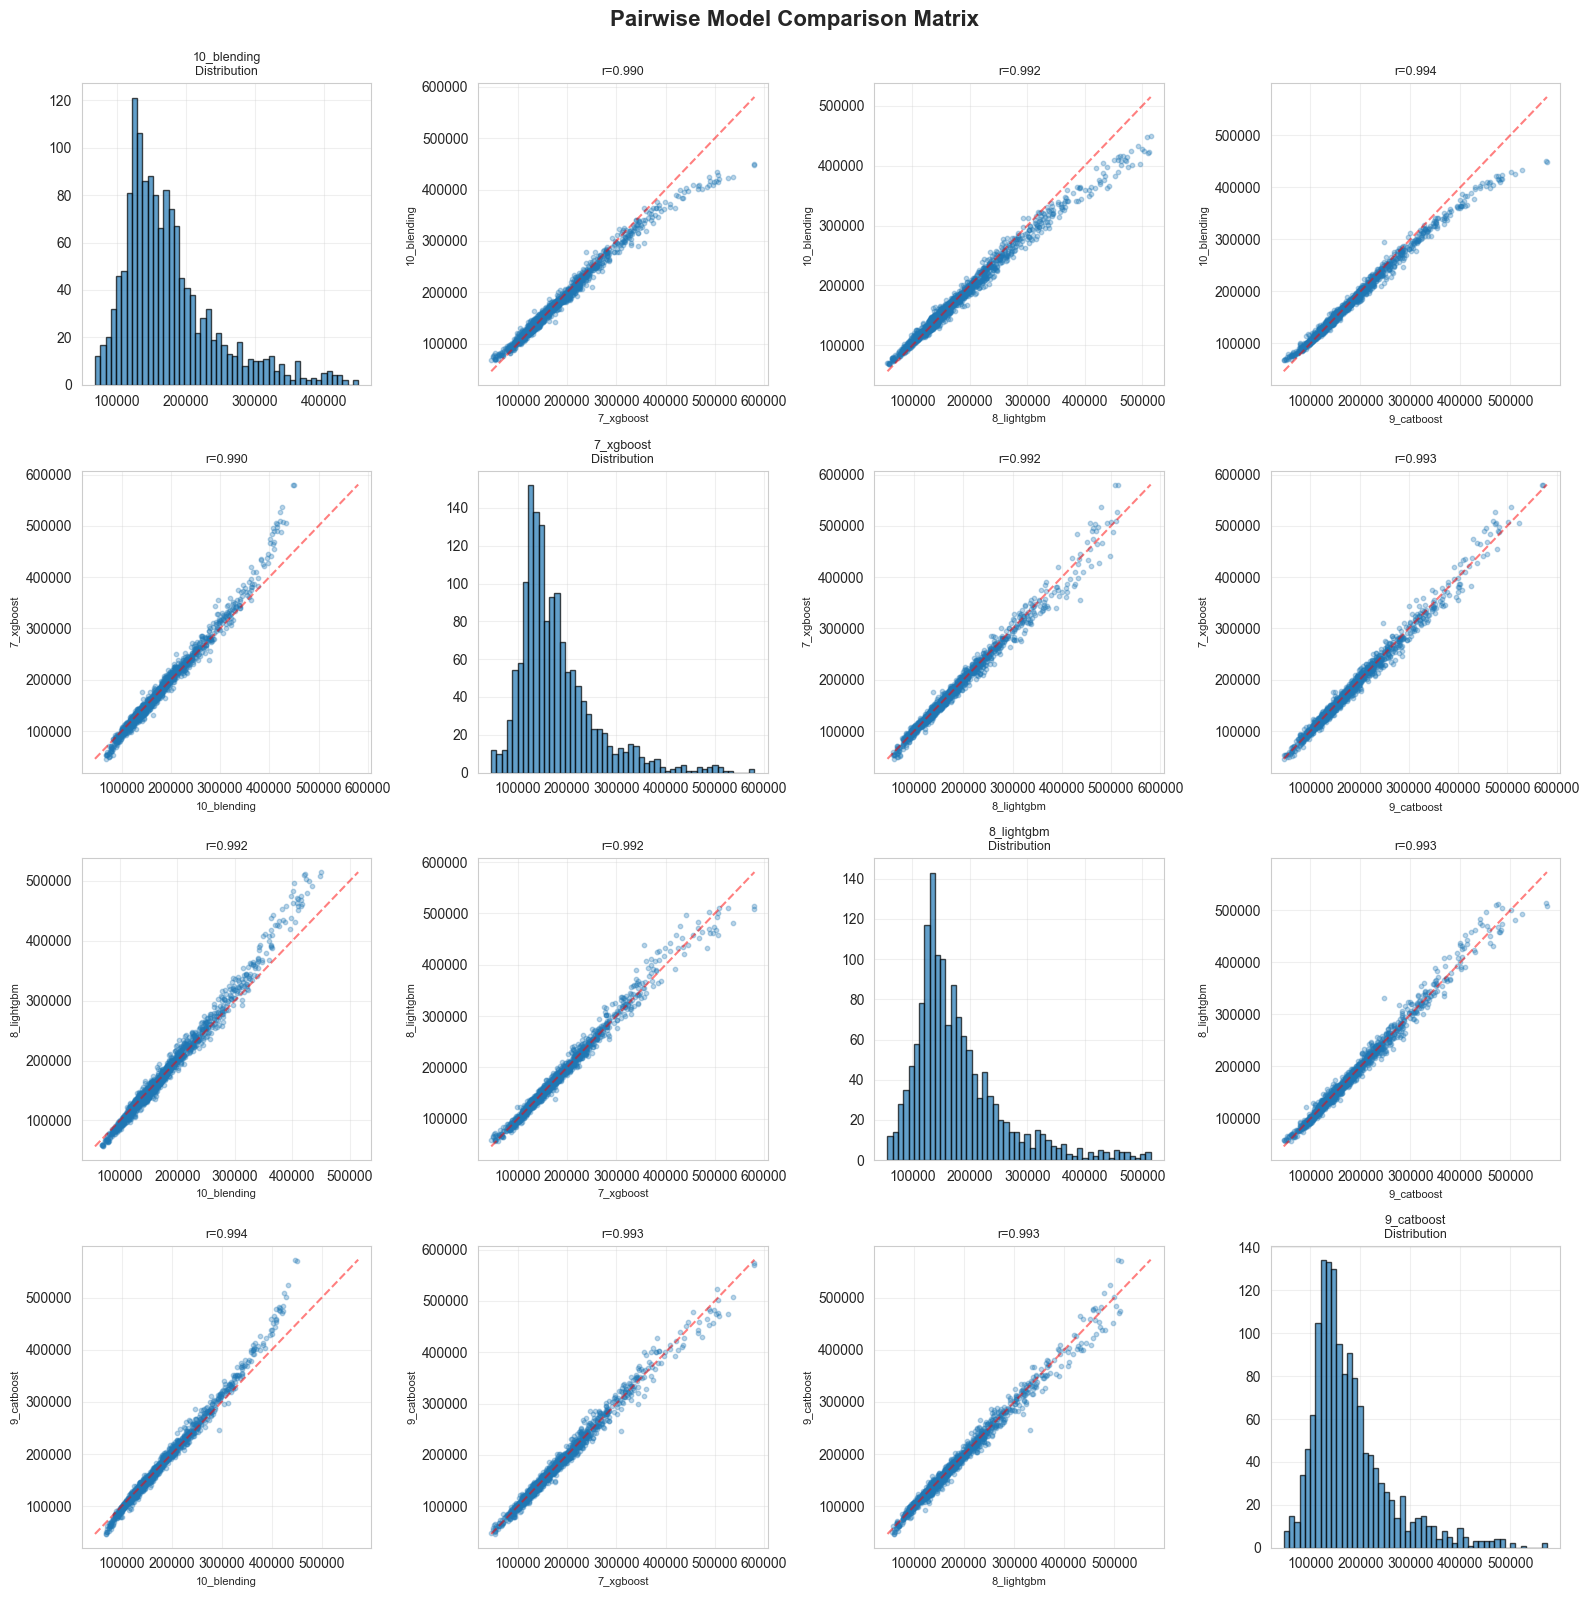

In [6]:
# Pairwise differences between top models
top_models = [m for m in valid_models if any(x in m.lower() for x in ['xgboost', 'lightgbm', 'catboost', 'blending', 'stacking'])]

if len(top_models) >= 2:
    print(f"\nPairwise Differences Between Top Models: {', '.join(top_models)}")
    print("="*80)
    
    for i, model1 in enumerate(top_models):
        for model2 in top_models[i+1:]:
            diff = df_valid[model1] - df_valid[model2]
            print(f"\n{model1} vs {model2}:")
            print(f"  Mean difference: ${diff.mean():,.2f}")
            print(f"  Std of differences: ${diff.std():,.2f}")
            print(f"  Max absolute difference: ${diff.abs().max():,.2f}")
            print(f"  Correlation: {df_valid[model1].corr(df_valid[model2]):.4f}")
    
    # Visualize pairwise comparisons
    if len(top_models) <= 5:  # Only if manageable number
        fig, axes = plt.subplots(len(top_models), len(top_models), figsize=(16, 16))
        for i, model1 in enumerate(top_models):
            for j, model2 in enumerate(top_models):
                ax = axes[i, j]
                if i == j:
                    # Diagonal: show distribution
                    ax.hist(df_valid[model1], bins=50, alpha=0.7, edgecolor='black')
                    ax.set_title(f"{model1}\nDistribution", fontsize=9)
                else:
                    # Off-diagonal: scatter plot
                    ax.scatter(df_valid[model2], df_valid[model1], alpha=0.3, s=10)
                    # Add diagonal line
                    min_val = min(df_valid[model1].min(), df_valid[model2].min())
                    max_val = max(df_valid[model1].max(), df_valid[model2].max())
                    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
                    ax.set_xlabel(model2, fontsize=8)
                    ax.set_ylabel(model1, fontsize=8)
                    corr = df_valid[model1].corr(df_valid[model2])
                    ax.set_title(f"r={corr:.3f}", fontsize=9)
                ax.grid(True, alpha=0.3)
        
        plt.suptitle("Pairwise Model Comparison Matrix", fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()


In [7]:
# Summary statistics table
print("\n" + "="*80)
print("DETAILED STATISTICAL SUMMARY")
print("="*80)
print(df_valid.describe().T.round(2))



DETAILED STATISTICAL SUMMARY
                  count       mean       std       min        25%        50%  \
10_blending      1459.0  175886.05  68336.89  68128.44  128489.69  159148.15   
5_random_forest  1459.0  177058.04  75144.06  55782.71  127456.11  157083.15   
6_svr            1459.0  177637.06  72158.65  51452.37  132558.62  156547.23   
7_xgboost        1459.0  177683.36  77974.00  45965.37  127512.46  157675.81   
8_lightgbm       1459.0  178422.40  78689.77  56649.38  128059.84  156882.31   
9_catboost       1459.0  177857.42  77745.74  46651.42  126904.71  158065.05   

                       75%        max  
10_blending      201776.75  449878.15  
5_random_forest  205966.35  540118.93  
6_svr            201465.64  558044.03  
7_xgboost        207738.71  580416.25  
8_lightgbm       206170.11  514619.69  
9_catboost       205834.23  573022.21  


## Key Findings

### Best Performing Models (by RMSE):
1. **Stacking Model** (RMSE: 0.112898) - Best overall performance
2. **XGBoost (Optimized)** (RMSE: 0.114356) - Best single model
3. **Ridge (CV)** (RMSE: 0.118331) - Best linear model
4. **LightGBM (Optimized)** (RMSE: 0.117945) - Strong gradient boosting
5. **CatBoost (Optimized)** (RMSE: 0.12017) - Good performance with GPU

### Model Categories:
- **Ensemble Models**: Stacking (best), Blending
- **Gradient Boosting**: XGBoost, LightGBM, CatBoost
- **Linear Models**: Ridge, Lasso, Elastic Net
- **Tree Models**: Random Forest
- **Kernel Methods**: SVR

### Notes:
- Models with exploded predictions (linear_regression, some ridge) should be excluded
- Stacking model combines 8 base models for best performance
- High correlation between gradient boosting models suggests similar feature importance
- Ensemble methods (blending/stacking) provide best generalization
